# Repetition Code on IQM Garnet

The repetition code is a simple error correction scheme that serves us as a fundamental demonstration of quantum error correction. 
Looking into error correction experiments is an essential step for building robust quantum computers that can operate in the presence of noise and other errors. This experiment helps us to understand how quantum information can be protected against bit-flip errors (where a qubit state $|0\rangle$ flips to $|1\rangle$ and vice versa).


In this notebook, 
* we run the experiments for a single round of stabilizer measurements of repetition codes on IQM Garnet with distances ranging from 3 to 10. 


<div style="background-color: white; margin: 20px 0px; padding: 20px; border-left: 3px solid rgb(222, 199, 84);">
You can learn more about quantum error correction in the corresponding modules on <a href="https://www.iqmacademy.com">IQM Academy</a>.
<div>

Let's get started performing the experiments on IQM Resonance. Ensure that on qBraid Lab, your "IQM Demo" environment is activated. If it's not, click on "Envs" on the top right, find the "IQM Demo" environment. If the environment is greyed out, click on "Add kernel." Choose the kernel when you run the notebook from the Python kernel selector. 

You are all set!

As we will use multiple physical qubits to form one logical qubit, we need to choose which qubits we use for encoding the data (blue), and which ones function as ancilla qubits (green) that are used to retrieve information on whether an error has occured.

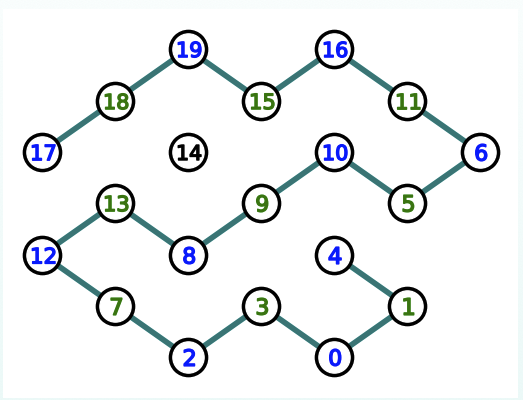

In [3]:
from PIL import Image
from IPython.display import display
img = Image.open('images/code-layout.png')
display(img)

## Defining the quantum circuit for the repetition code experiment

The core idea behind the **repetition code** is to encode a logical quantum bit (qubit) into several physical qubits. By distributing the information across multiple qubits, it becomes possible to detect and correct errors that might affect individual qubits. 

The simplest form of the repetition code is the three-qubit repetition code, which protects against a single bit-flip error.

In a nutshell (for three qubits):
* We encode the logical qubit state $|ψ\rangle = α|0\rangle + β|1\rangle$ is encoded across three physical qubits. So, if we want to encode the logical $|0\rangle$, we prepare three physical qubits in the state $|000\rangle$. Similarly, to encode the logical $|1\rangle$, we prepare them in the state $|111\rangle$. For a general state  $|ψ\rangle = α|0\rangle + β|1\rangle$, the encoded state is  $|ψ\rangle_L = α|000\rangle + β|111\rangle$. 
* To **detect errors**, we measure the parity of pairs of qubits, which should always be even. However, we don't do this directly, but by using additional **ancilla qubits** that help us measure the parity without collapsing the encoded state. These parity checks are called **stabilizers**, and correspond to measuring a **stabilizer operator** $S_i = Z_i Z_{i+1}$. For the three-qubit repetition code, we measure the stabilizer operators $S_1$ and $S_2$.  
* Based on the outcome of the parity measurements, we can infer which qubit has undergone a bit-flip error and **correct it**. For example, a bit-flip on the qubit 1 will change the parity of the pair of qubits 1 and 2, and will be detected with the ancilla. If the parity of the pair 1-2 is odd, and the parity of pair 2-3 is even, we can infer that a bit-flip happened on the first qubit. Note that this protocol fails if we have more than one bit-flip error in one round.



In [4]:
from qiskit import QuantumCircuit

import pymatching
from typing import *


import numpy as np
import matplotlib.pyplot as plt 


def repetition_circuit_generator(state = 0, distance = 10, 
                                 path =  [17,18,19,15,16,11,6,5,10,9,8,13,12,7,2,3,0,1,4]):
    """
    This function generates the circuit for a round of repetition code stabilizer measurement 
    including the final readout.
    Returns: 
    - The circuit
    - The list of data qubits
    - The list of ancilla qubits
    """
    
    # we will measure the first qubits in the path ("distance" data qubits and "distance-1" ancillas)
    qb_to_measure = list(path[:(distance*2-1)])
    qc = QuantumCircuit(20,20)
    
    data_qubits, ancilla_qubits = [],[]
    # data qubits correspond to even index in the path, ancilla to odd index
    for i in range(distance * 2 - 1):
        if i%2==0:
            data_qubits.append(path[i])
        else:
            ancilla_qubits.append(path[i])
    
    ### Start of the circuit ###
    # Check if we want to prepare the logical qubit in state 1
    if state in [1,"1"]:
        # We apply X on all data qubits
        qc.x(data_qubits)
        
    ### Stabilizer measurement circuit ###
    
    # 1) Hadamard on all ancilla qubits
    qc.h(ancilla_qubits)
    
    # 2) CZ gate between ancilla qubits and the previous qubit
    for i in range(distance-1):
        # CZ gate between data qubit (2i) and ancilla (2i+1)
        qc.cz(path[2*i], path[2*i + 1])
    
    # 3) CZ gate between ancilla qubits and the next data qubit
    for i in range(distance-1):
        # cz gate between data qubit (2i) and ancilla (2i+1)
        qc.cz(path[2*(i+1)], path[2*i + 1])
    
    # 4) Hadamard on all ancilla qubits
    qc.h(ancilla_qubits)
    
    # 5) Measuring all qubits
    qc.measure(qb_to_measure,qb_to_measure)
    
    return qc, data_qubits, ancilla_qubits
    

Let's get a feeling for how such a circuit looks like:

The circuit used for the measurement of stabilizers is very simple, and consists on 4 steps. The gates on each step can be executed in parallel for all ancillas:

 1) Hadamard on the ancillas,

 2) CZ gate from each ancilla to the previous qubit in the line,

 3) CZ gate from each ancilla to the next qubit in the line

 4) Hadamard on the ancillas 

After that, we can measure the ancilla qubits to obtain the measurement of the stabilizer $S_i = Z_iZ_{i+1}$. A sketch of the circuit is shown in the next figure, where $q_2$ is the ancilla qubit used to measured the stabilizer. The ancilla qubit is initialized in $|0\rangle$ state:

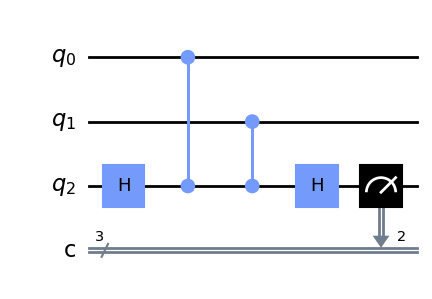

In [6]:
img = Image.open('images/stabilizer-circuit.png')
display(img)

Let's see that in action for the distance 3 repetition code:

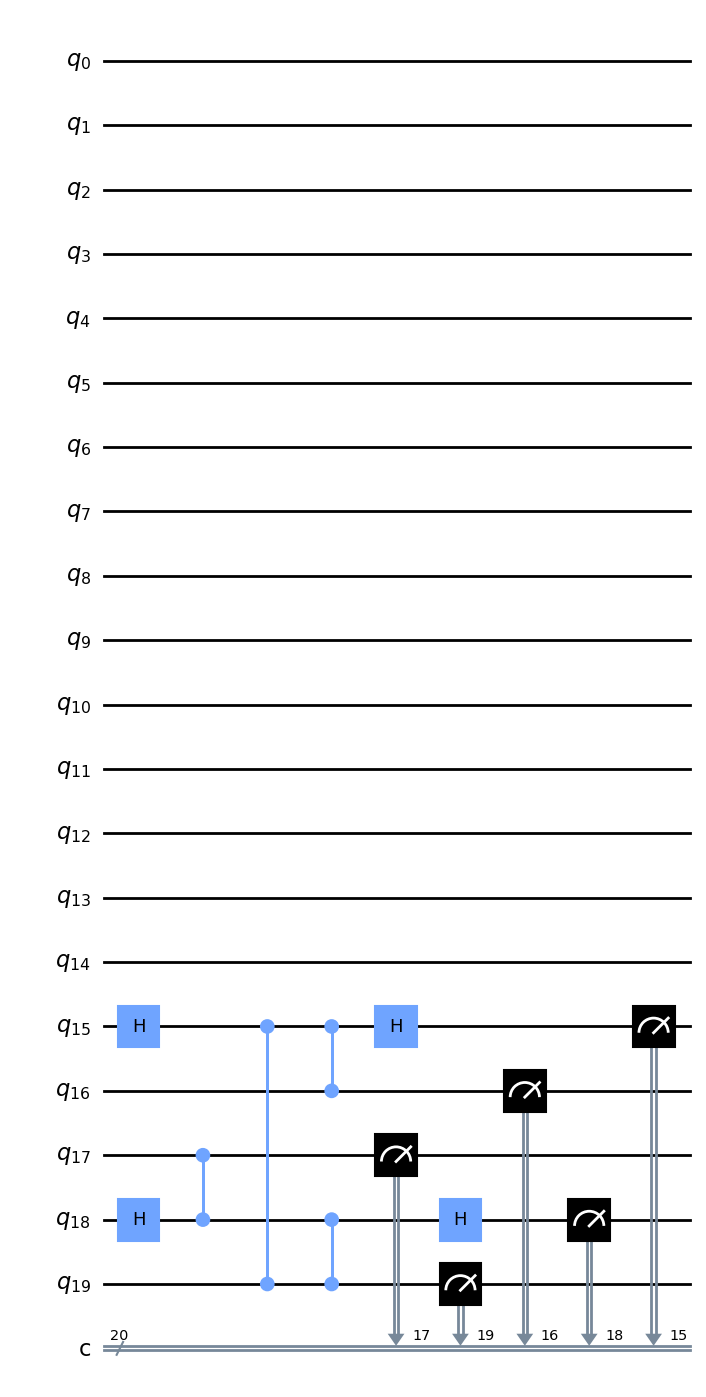

In [7]:
qc, data_qubits, ancilla_qubits = repetition_circuit_generator(state=0, distance=3)
qc.draw(output='mpl', style='clifford')

You can clearly spot the data qubits $q_{16}$, $q_{17}$ and $q_{19}$ as well as the ancillary qubits $q_{15}$ and $q_{18}$. In practice, you would measure the ancillary qubits repeatedly during circuit execution in order to correct errors on the fly. However, for our experiment, we will test a single round of stabilizer measurement, after which we will also measure all the data qubits. This final measurement of the data qubits allows us to have an **effective second round of parity measurements** (inferred directly from the data qubits). The results of the stabilizer measurements obtained from the ancilla qubits, together with this final effective round of parity measurements, can be used to infer a correction for the final state. After applying the correction (in postprocessing), we can check if we succeeded in recovering the original logical state prepared.


## Process and decode the output

Let's define functions that do the detection and the correction for us in order to calculate the logical error rate.

In [8]:
def read_output(readout, data_qubits, ancilla_qubits):
    """ 
        This function takes a readout from qiskit, and translates it to a syndrome and data readout
    """
    
    data = ""
    syndrome = ""
    
    for index in data_qubits:
        data += readout[-1-index]
    for index in ancilla_qubits:
        syndrome += readout[-1-index]
    return data, syndrome
    

In [9]:
read_output("00000000000000100000", data_qubits, ancilla_qubits)

('000', '00')

### Decoding with Minimum Weight Perfect Matching (MWPM) 

In order to interpret the results from the error syndromes in our quantum error correction experiment, we employ the Minimum Weight Perfect Matching (MWPM) algorithm. 

The MWPM algorithm works by identifying pairs of **excitations** (stabilizers with changed parity) that minimize the total "cost" of correcting those errors by constructing a matching graph. The cost is typically defined by the number of errors (bit-flips or measurement errors) assigned to a given matching. In the context of a the repetition code, each possible error (like a bit flip or measurement error) generates a pair of excitations at the endpoints of the error chain. The goal of MWPM is to connect these excitations in such a way that the total length of the connections (and thus the number of qubits that need to be corrected) is minimized, and all excitations are connected.

You can learn more about the Minimum Weight Perfect Matching (MWPM) algorithm [here](https://www.iqmacademy.com/learn/qec2/03-decoding-algorithms/).

In [10]:
import networkx as nx

def generate_matching_graph(distance = 3):
    """
    This function generates the matching graph for the repetition code of given distance
    """
    # generates the matching graph for the repetition code of given distance
    # includes two rounds of stabilizer measurement, 
    # and potential measurement errors on the first round
    # includes boundary nodes on the sides of the code.
    # For distance d, we have d-1 stabilizers
    
    
    g = nx.Graph() 
    
    edgeDict = {} # equivalence between index of an edge and pair of nodes
    edgesinDict = {} # complementary of edgeDict
    correctionDict = {} # to which qubit should we apply a correction
    edgecount = 0
     
    # adding nodes for each stabilizer, and two boundary nodes (one on the left and one on the right)
    # remember we have (d-1) stabilizers and 2 boundary nodes
    num_nodes_per_round =  distance-1 + 2
    for t in range(2):
        # we have 2 rounds of stabilizer results in this experiment
        for k in range(distance+1):
            # the boundary nodes are the nodes 0 and 
            if k==0 or k>=distance:
                g.add_node(k + num_nodes_per_round * t,is_boundary = True)
            else:
                g.add_node(k + num_nodes_per_round * t)

    # now we add the edges between nodes
    
    for t in range(2):
        # we have 2 rounds of stabilizer results in this experiment
        for k in range(distance):
            index= k + t * num_nodes_per_round
            
            g.add_edge(index,index + 1, fault_ids= edgecount )
    
            # recording the edge
            edgesinDict[(index,index + 1)] = edgecount
            edgeDict[edgecount] = (index, index+1)
            
            # this edge corresponds to a correction on qubit k
            correctionDict[edgecount]  = k
            edgecount+=1


    # now we add the temporal edges
    for k in range(1,distance):
        
        index= k + t * num_nodes_per_round

        g.add_edge(index,k, fault_ids= edgecount )

        # recording the edge
        edgesinDict[(k,index)] = edgecount
        edgeDict[edgecount] = (k, index)
        
        #this edge does not correspond to a correction
        
        edgecount += 1
        

    return g,edgeDict, correctionDict
    

**Example of Matching Graph with distance 5:**

The function above constructs a graph for the Minimum Weight Perfect Matching (MWPM) algorithm, based on two rounds of stabilizer measurements. Connections between stabilizers within the same round reflect potential single qubit errors, as such an error would activate both stabilizers. Connections between the same stabilizer across sequential rounds indicate potential single measurement errors, which would affect both rounds.

Additionally, we place virtual stabilizers at the boundaries of the code. These virtual stabilizers allow the correction of errors on the first and last qubits, which only generate a single excitation. That excitation can then be matched to a virtual stabilizer in the boundary. The details of matching to boundary stabilizers are handled by pymatching, and we only need to mark these virtual stabilizers as boundary.

**Note**: Virtual stabilizers on the boundary are excluded from "time" connections as they are not measurable.


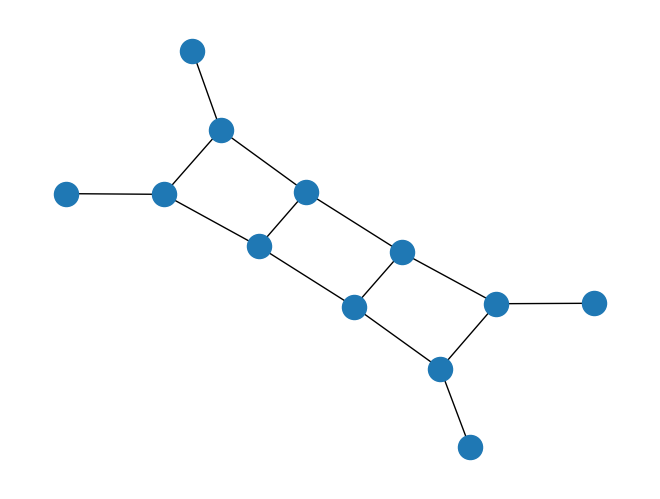

In [11]:
graph, edgeDict, correctionDict = generate_matching_graph(5)
nx.draw_spring(graph)

In [12]:
def syndrome_for_pymatching(data_readout, ancilla_readout):
    """
    This function takes the readout of the data and the ancillas, and translates it to a syndrome
    that can be interpreted by PyMatching
    """
    
    distance = len(data_readout)
    
    # finding the syndrome obtained from the direct data readout 
    # ( parity of consecutive qubits "i" and "i+1" )

    syndrome_from_data = []
    for i in range(distance-1):
        parity = (int(data_readout[i]) + int(data_readout[i+1]))%2
        syndrome_from_data.append( parity )
    # rewriting the ancilla syndrome as a np.array
    syndrome_from_ancilla = np.zeros(distance-1)
    for i in range(len(ancilla_readout)):
        syndrome_from_ancilla[i] = int(ancilla_readout[i])
        
    # the full syndrome contains 2 rounds, each of which has 
    # distance-1 stabilizer readouts and 2 boundary nodes at (0,d) positions
    syndrome = np.zeros((distance+1)*2)
    
    # first we add the syndrome from the ancillas:
    syndrome[1:distance] += syndrome_from_ancilla
    # we add it again to the second round, since the syndrome from 
    # pymatching should be the DIFFERENCE between the syndromes of both rounds
    syndrome[(distance+2):-1] += syndrome_from_ancilla
    
    # now we add the syndrome obtained from the data qubits
    syndrome[(distance+2):-1] += syndrome_from_data
    
    # and take modulo 2
    syndrome %= 2
    
    return syndrome    

### Calculate the logical error rate
Now that we know about the presence of logical errors, we can calculate the logical error rate.
We split this task in two. First, we need to be able to find the logical state after applying the corrections inferred from the measurements. Then we take the information from many samples to estimate the logical error rate.

In [13]:
def find_logical_state_of_reading(reading, data_qubits, ancilla_qubits):
    """
    finds the logical state corresponding to a given output of the rep. code experiment 
    after applying MWPM on the results of the stabilizer measurements and the 
    final readout of data qubits. 
    Returns:
    - the logical state
    """

    # first we organize the data from the input 
    data, ancilla = read_output(reading, data_qubits, ancilla_qubits)
    distance = len(data)
    syndrome = syndrome_for_pymatching(data, ancilla)
    
    # generate graph for matching
    graph, edgeDict, correctionDict = generate_matching_graph(distance)
    matching_graph = pymatching.Matching.from_networkx(graph)
    
    # apply MWPM
    match = matching_graph.decode(syndrome)
    
    # Find the correction corresponding to the matching
    corrected = np.array([int(i) for i in data]) 
    for i in range(len(match)):
        if match[i]>0:
            if i in correctionDict:
                corrected[correctionDict[i]] += 1            
    corrected %= 2
    
    # after correction, the state should be either [0,0,0,...] or [1,1,1,...]
    return corrected[0]

Now let's define a function that loops over all measurement outcomes to calculate the **logical error rate**.

In [14]:
def logical_error_rate_from_samples(samples, distance, state = 0):
    """
    calculates the logical error rate from the measured samples.
    """

    fail_count = 0
    total_count = 0
    
    # get the lists of data and ancilla qubits
    q_circuit, data_qubits,ancilla_qubits = repetition_circuit_generator(state = state, distance = distance )

        
    # loop over all measurement outcomes
    for reading in samples:
        # how many times was this outcome measured
        counts = samples[reading]
        total_count += counts
        
        # we find if the reading corresponds to a failure event
        failed = find_logical_state_of_reading(reading, data_qubits, ancilla_qubits)

        # we add the counts to the failed if the logical state was 1
        fail_count += failed * counts

    logical_error_rate = fail_count/total_count
    
    if state>0:
        # if the logical state prepared was 1, then we have computed the probability of success
        logical_error_rate = 1 - logical_error_rate
    
    # now we estimate the error:
    p = logical_error_rate
    error = np.sqrt(p * (1-p) / total_count)
    
    return logical_error_rate, error


# Running the circuits on Resonance

Now, we are finally ready to run the circuits on IQM Resonance, and see how we can improve the logical error rate by increasing the distance of our error correction code.

For this experiment we will need a higher shot number then we typically do. Also, we will store the results of our experiments in a folder called `data`. Make sure to create this folder **manually** in the same folder as this notebook before running the next cell.

In [15]:
shots = 10000
distances = [3,4,5,6,7,8,9,10]

# Make sure to create a folder data before running this cell
folder = "./data/"

In order to access IQM Garnet through IQM Resonance, you will need to create an API Token. Copy the token, execute the cell, and paste the token to store it as an environment variable (or follow the guidelines for your system to create an environment variable).

In [ ]:
import os
os.environ["IQM_TOKEN"] = input()

In [18]:
from iqm.qiskit_iqm import IQMProvider

# Instead of setting the environment variable, you could add the token as an argument to the IQMProvider constructor
provider=IQMProvider(url="https://cocos.resonance.meetiqm.com/garnet")
backend = provider.get_backend()

In [ ]:
%%time
import pickle
from qiskit import transpile

state = 0

print("---------------------------")
print("Running the repetition code in Resonance for state " + str(state))
print("---------------------------")

for distance in distances:

    quantum_circuit, data_qubit_indices, ancilla_qubit_indices = repetition_circuit_generator(state=state, distance=distance)

    qc_transpiled = transpile(quantum_circuit, backend)
    job = backend.run(qc_transpiled, shots=shots)
    
    import qiskit
    if qiskit.__version__ < '1.0.0':
        # The job monitor is only compatible with qiskit versions smaller than 1.0
        from qiskit.tools.monitor import job_monitor
        job_monitor(job)


    result_dict = job.result().get_counts()

    filename = folder + "repetition-code-" + str(state) + "-d" + str(distance) + ".dat"

    with open(filename, 'wb') as fp:
        pickle.dump(result_dict, fp)
        print('Data saved successfully to ' + filename)


Now, let's run the sequence again for the logical state $|1\rangle$.

In [ ]:
state = 1 

print("---------------------------")
print("Running the repetition code in Resonance for state " + str(state))
print("---------------------------")

for distance in distances:

    quantum_circuit, data,ancilla = repetition_circuit_generator(state = state, distance = distance )

    qc_transpiled = transpile(quantum_circuit, backend)
    job = backend.run(qc_transpiled, shots=shots)

    import qiskit
    if qiskit.__version__ < '1.0.0':
        # The job monitor is only compatible with qiskit versions smaller than 1.0
        from qiskit.tools.monitor import job_monitor
        job_monitor(job)


    result_dict = job.result().get_counts()

    filename = folder + "repetition-code-" + str(state) + "-d" + str(distance) + ".dat"
    
    with open(filename, 'wb') as fp:
        pickle.dump(result_dict, fp)
        print('Data saved successfully to '+filename)

## Analyzing the Experimental Results

In this section of the notebook, we analyze the results from our quantum error correction experiment conducted using a repetition code. The experiment involved running a single round of stabilizer measurements to detect and correct errors across various code distances. We specifically looked at how effectively the repetition code could preserve the logical states $|0\rangle$ and $|1\rangle$.


Below, we display the results from our experiments, illustrating the logical error rates observed for each code distance using IQM Garnet.

In [ ]:
%%time
# Loading data from the experiment
states = [0,1]
distances = [3,4,5,6,7,8,9,10]

# array of results for the logical error rate and its standard deviation std
logical_error_rates= np.zeros((len(states), len(distances)))
std_error_rates= np.zeros((len(states), len(distances)))

for state in states:
    for distance_index in range(len(distances)):
        distance = distances[distance_index]
        
        # details of the files to load
        date = "2024-03-08"
        folder = "./data/"
        filename = folder + "repetition-code-"+str(state)+"-d"+str(distance)+".dat"
        with open(filename,'rb') as f:
            repetition_samples = pickle.load(f)
            
        logical_error_rate, error =  logical_error_rate_from_samples(repetition_samples, distance, state)
        
        logical_error_rates[state,distance_index] = logical_error_rate
        std_error_rates[state, distance_index] = error


# plotting the results
plt.errorbar(distances,logical_error_rates[0,:], 2*std_error_rates[0,:], label = "Logical state |0>")
plt.errorbar(distances,logical_error_rates[1,:], 2*std_error_rates[1,:], label = "Logical state |1>")
plt.xlabel("Distance")
plt.ylabel("Logical Error Rate")
plt.title("Repetition Code on IQM Garnet")
plt.yscale("log")
plt.legend()


As we see, we can significantly decrease our logical error rate by using more qubits to encode our information. For high enough distance, the suppression of errors is so effective that we do not sample a single logical error in $10^4$ shots.

In [ ]:
logical_error_rates

In [23]:
# Copyright 2024 IQM Quantum Computers (Pedro Parrado, Stefan Seegerer)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.